In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA

# Opening the Dataset

In [2]:
# Opening the CIFAR-10 dataset file and loading the data into 32x32x3 numpy arrays

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

with open('cifar-10-batches-py/test_batch', 'rb') as fo:
    dict_test = pickle.load(fo, encoding='bytes')
    data_test = dict_test[b'data']
    labels_test = dict_test[b'labels']
    data_test = data_test.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")/255
    labels_test = np.array(labels_test)

data = np.zeros((10, 32, 32, 3))
labels = np.zeros((10, 1))
indices = []
for i in range(10000):
    if len(indices)==10:
        break
    if labels_test[i] not in indices:
        data[labels_test[i]] = data_test[i]
        labels[labels_test[i]] = labels_test[i]
        indices.append(labels_test[i])

# 1. Convolution

In [3]:
def dot_product(a, b):
    m, n, o = a.shape
    p, q, r = b.shape
    if m != p or n != q or o != r:
        print("Error: The dimensions of the two matrices are not the same")
    sum=0
    for i in range(m):
        for j in range(n):
            for k in range(o):
                sum+=a[i][j][k]*b[i][j][k]
    return sum

In [4]:
def conv2d_my(input, padding=0, stride=1, kernel_size=3, filter = np.ones((3,3,3)), activation=None):
    # print("Input shape: ", input)
    m, n, o = input.shape
    # print(filter.shape)
    p, q, r = filter.shape
    if o != r :
        raise ValueError(f"Dimensions of matrices do not match: {o} != {r}")
    # print(padding)
    if padding:
        input = np.pad(input, ((padding, padding), (padding, padding), (0,0)), 'constant')
    # print("Input shape after padding: ", input)
    output = np.zeros((int((m-kernel_size+2*padding)/stride + 1), int((n-kernel_size+2*padding)/stride + 1),1))
    # print("Output Size: ", output.shape)
    for i in range(0, m-kernel_size+1, stride):
        for j in range(0, n-kernel_size+1, stride):
            output[i][j][0] = dot_product(input[i:i+kernel_size, j:j+kernel_size,:], filter)
    # print(output.shape)
    if activation == "ReLU":
        output = np.maximum(output, 0)
    elif activation == "Sigmoid":
        output = 1/(1+np.exp(-output))
    elif activation == "Tanh":
        output = np.tanh(output)
    elif activation == "PReLU":
        output = np.maximum(output, 0.01*output)
    elif activation == None:
        pass
    return output

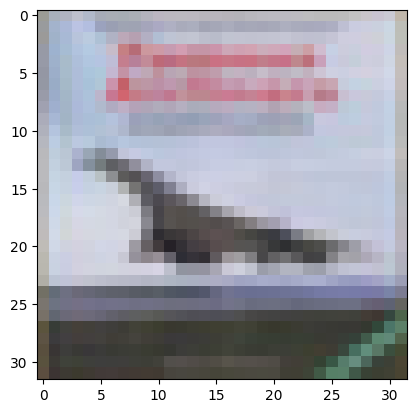

(32, 32, 3)


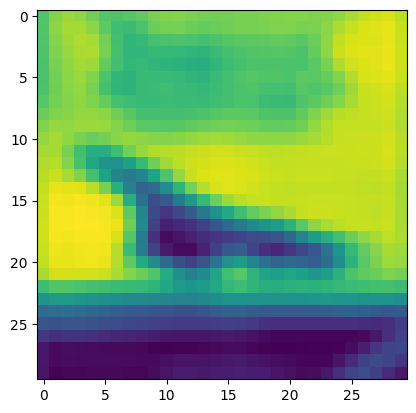

In [5]:
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
ans_my = conv2d_my(input=a, padding=0, stride=1, kernel_size=3)

# Opening iith.png file
img = data[0]
img = np.array(img)
plt.imshow(img)
plt.show()
print(img.shape)

conv_aft = conv2d_my(input=img, padding=0, stride=1, kernel_size=3, filter = np.ones((3,3,3)), activation="ReLU")
plt.imshow(conv_aft)


# 2. Pooling Function

In [6]:
def pooling(input, kernel_size=2, stride=2, mode='Max'):
    # print(input.shape)
    size = input.shape
    if len(size) == 2:
        p, q = input.shape
        r = 1
    elif len(size) == 3:
        p, q, r = input.shape
    # print(p,q,r)
    # print(int((p-kernel_size)/stride) + 1,int((q-kernel_size)/stride) + 1, r)
    output = np.zeros((int((p-kernel_size)/stride) + 1,int((q-kernel_size)/stride) + 1, r))
    # print(output.shape)
    a, b, c = output.shape
    for k in range(c):
        for i in range(a):
            for j in range(b):
                if mode == 'Max':
                    output[i,j,k] = np.max(input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k])
                elif mode == 'Min':
                    output[i,j,k] = np.min(input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k])
                elif mode == 'Mean':
                    output[i,j,k] = np.mean(input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k])
    
    return output


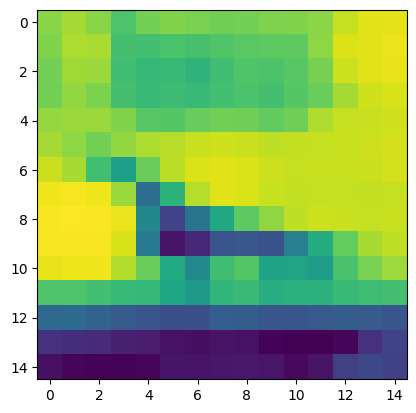

In [7]:
# Implementing Pooling Function
pool_aft = pooling(conv_aft,2,2,'Max')
plt.imshow(pool_aft)

# 3. Convolution Layer Function

In [8]:
def conv_layer_function(input, number_of_feature_maps=1, kernel_size=3, stride=1, padding=0, activation=None, kernel=None):
    m, n, o = input.shape
    output = np.zeros((int((m-kernel_size+2*padding)/stride + 1), int((n-kernel_size+2*padding)/stride + 1), number_of_feature_maps))
    if kernel == None:
        kernel = np.ones((kernel_size, kernel_size, o, number_of_feature_maps))
    for i in range(number_of_feature_maps):
        temp = conv2d_my(input, padding=padding, stride=stride, filter=kernel[:,:,:,i], kernel_size=kernel_size, activation=activation)
        a, b, c = temp.shape
        output[:,:,i] = temp.reshape(a,b)
    return output

(30, 30, 1)


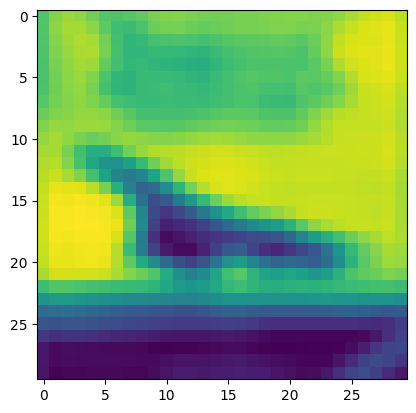

In [9]:
conv_aft = conv_layer_function(input=img, padding=0, number_of_feature_maps=1,stride=1, kernel_size=3, activation="ReLU")
print(conv_aft.shape)
conv_aft = conv_aft/255
plt.imshow(conv_aft)


# 4. Pooling Layer Function

In [10]:
def pooling_layer_function(input, kernel_size=2, stride=2, mode='Max', global_average_pooling=False):
    m, n, o = input.shape
    # print(f"Input shape: {m, n, o}")
    if global_average_pooling:
        kernel_size = m
        stride = m
    output = np.zeros((int((m-kernel_size)/stride) + 1,int((n-kernel_size)/stride) + 1, o))
    # print(f"Output shape: {output.shape}")
    p, q, r = input.shape
    # print(int((p-kernel_size)/stride) + 1,int((q-kernel_size)/stride) + 1, r)
    output = np.zeros((int((p-kernel_size)/stride) + 1,int((q-kernel_size)/stride) + 1, r))
    # print(output.shape)
    a, b, c = output.shape
    for k in range(c):
        for i in range(a):
            for j in range(b):
                if mode == 'Max':
                    output[i,j,k] = np.max(input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k])
                elif mode == 'Min':
                    output[i,j,k] = np.min(input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k])
                elif mode == 'Mean':
                    output[i,j,k] = np.mean(input[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k])
        
    return output

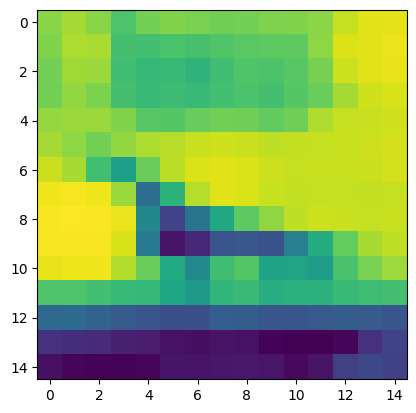

In [11]:
pool_aft = pooling_layer_function(conv_aft,2,2,'Max')
plt.imshow(pool_aft)

# 5. Flattening

In [12]:
def flatten(input, p):
    m, n, o = input.shape
    output = input.reshape(m*n*o, 1)
    a = np.random.rand(p,m*n*o)
    output = np.dot(a, output)
    return output

# 6. MLP

In [13]:
def multi_layered_perceptron(input, number_of_hidden_layers=1, size = np.array([5]), non_Linear_Function='ReLU', output_size=1,softmax=False):
    m, n = input.shape
    output = np.zeros((output_size, 1))
    if len(size) != number_of_hidden_layers:
        raise ValueError(f"Size of hidden layers and number of hidden layers do not match: {len(size)} != {number_of_hidden_layers}")
    for i in range(number_of_hidden_layers):
        if i == 0:
            temp = np.random.rand(size[i], m)
            output = np.dot(temp, input)
        else:
            temp = np.random.rand(size[i], size[i-1])
            output = np.dot(temp, output)
        if non_Linear_Function == 'ReLU':
            output = np.maximum(output, 0)
        elif non_Linear_Function == 'Sigmoid':
            output = 1/(1+np.exp(-output))
        elif non_Linear_Function == 'Tanh':
            output = np.tanh(output)
        elif non_Linear_Function == 'PReLU':
            output = np.maximum(output, 0.01*output)
    temp = np.random.rand(output_size, size[number_of_hidden_layers-1])
    output = np.dot(temp, output)

    if softmax:
        output = np.exp(output)
        output = output/np.sum(output)

    return output

# 7. Feed Forward Path

In [14]:
def forward_CNN(input):
    conv_aft = conv_layer_function(input=input, padding=0, number_of_feature_maps=16,stride=1, kernel_size=3, activation="Sigmoid")
    # print(conv_aft.shape)
    pool_aft = pooling_layer_function(conv_aft,2,2,'Max')
    # print(pool_aft.shape)
    conv_aft1 = conv_layer_function(input=pool_aft, padding=0, number_of_feature_maps=8,stride=1, kernel_size=3, activation="Sigmoid")
    # print(conv_aft1.shape)
    pool_aft1 = pooling_layer_function(conv_aft1,2,2,'Max')
    # print(pool_aft1.shape)
    pool_aft2 = pooling_layer_function(pool_aft1,2,2,'Max', global_average_pooling=True)
    # a, b, c = pool_aft2.shape
    # print(pool_aft2.shape)
    flat = flatten(pool_aft2, 8)
    # print
    mlp_aft = multi_layered_perceptron(flat, number_of_hidden_layers=1, size = np.array([flat.shape[0]]), non_Linear_Function='Sigmoid', output_size=10,softmax=True)
    # print(mlp_aft.shape)
    return mlp_aft, flat

Output : [[0.06717731]
 [0.00730378]
 [0.06639977]
 [0.05560858]
 [0.26688917]
 [0.04136948]
 [0.25238425]
 [0.02048914]
 [0.13592736]
 [0.08645116]]


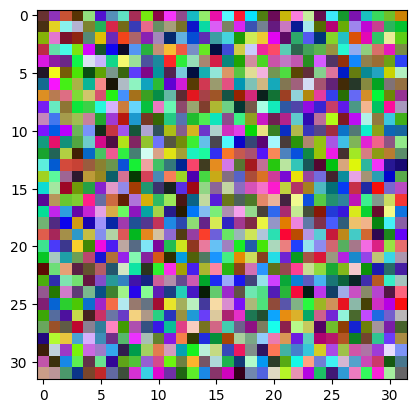

In [15]:
a = np.random.rand(32,32,3)
plt.imshow(a)
b, _ = forward_CNN(a)
print(f'Output : {b}')

# Question 8

In [16]:
for i in range(10):
    print(f'Output for {i} : ',end='')
    a, _ = forward_CNN(data[i])
    for j in range(10):
        print(f'{a[j]} ', end='')
    print()

Output for 0 : [0.02764083] [0.07948255] [0.14962776] [0.01131491] [0.10594757] [0.20876172] [0.34056931] [0.01970878] [0.04131576] [0.01563081] 
Output for 1 : [0.13054525] [0.02427461] [0.22394701] [0.17518] [0.02862028] [0.01905001] [0.19518558] [0.02609392] [0.02951352] [0.14758983] 
Output for 2 : [0.05458528] [0.04937189] [0.0645926] [0.04247885] [0.29535668] [0.11588592] [0.04620967] [0.0214606] [0.03336396] [0.27669455] 
Output for 3 : [0.04809989] [0.14515869] [0.10866808] [0.04155393] [0.11071319] [0.10338795] [0.02712752] [0.13556444] [0.24949588] [0.03023042] 
Output for 4 : [0.07936495] [0.04432783] [0.06079127] [0.3741191] [0.12395805] [0.0351254] [0.07244386] [0.04956657] [0.06910984] [0.09119312] 
Output for 5 : [0.06092291] [0.09601169] [0.0456516] [0.18159826] [0.13897046] [0.0601235] [0.0095863] [0.03970711] [0.12225487] [0.24517331] 
Output for 6 : [0.01603856] [0.06658654] [0.25579611] [0.0564231] [0.06946941] [0.12378121] [0.03287131] [0.13593749] [0.21699536] [0.

# 8 a)
As we can see the ouput of the data for each of the classsification, the ouput here shows no trend because the model is not yet trained and gives the values in a random way.


In [17]:
a = np.zeros(10)
data_new = np.zeros((30, 32, 32, 3))
labels_new = np.zeros((30, 1)) 
count=0
for i in range(10000):
    if a[labels_test[i]] < 3:
        a[labels_test[i]] += 1
        data_new[count] = data_test[i]
        labels_new[count] = labels_test[i]
        count += 1


In [18]:
flat_output = np.zeros((30, 8))
for i in range(30):
    _, b = forward_CNN(data_new[i])
    flat_output[i] = b.reshape(8)


In [19]:
pca = PCA(n_components=2)
pca.fit(flat_output)
pca.transform(flat_output)

array([[ 0.35443188, -1.84748107],
       [ 0.74566275, -1.68283401],
       [-1.16738969,  0.01317015],
       [ 0.08328001,  0.12543404],
       [-0.54889811, -0.98179596],
       [-1.57976422,  1.93793695],
       [-0.05691246, -0.25982128],
       [-0.86696759,  0.14495718],
       [ 0.72677078, -0.1931325 ],
       [-0.41671385, -0.3444774 ],
       [ 0.31112167, -0.18518033],
       [ 1.06223215,  0.13607661],
       [ 0.83616103, -0.80478613],
       [-1.12396758, -0.91265179],
       [ 0.06091179,  0.00390844],
       [ 1.35529742,  0.78905322],
       [-0.89331042,  1.40787791],
       [-0.06517555, -0.36690805],
       [ 0.06635935, -1.26233755],
       [ 0.19228833, -0.47819902],
       [-0.47984237,  2.97922708],
       [ 2.84676589, -0.04196732],
       [-1.1930475 , -0.02584722],
       [-2.19546128, -0.38049836],
       [ 0.0836485 , -0.06484585],
       [-0.24694348, -0.13377303],
       [ 0.51079273, -0.18387074],
       [ 2.40528428,  1.91163008],
       [-0.98131594,

/var/folders/9q/bft9r4494rv8r0696_gxrbp80000gn/T/ipykernel_6049/4170867438.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(flat_output[:,0], flat_output[:,1], c=colors[labels_new.reshape(30).astype(int)], cmap=plt.cm.Spectral)


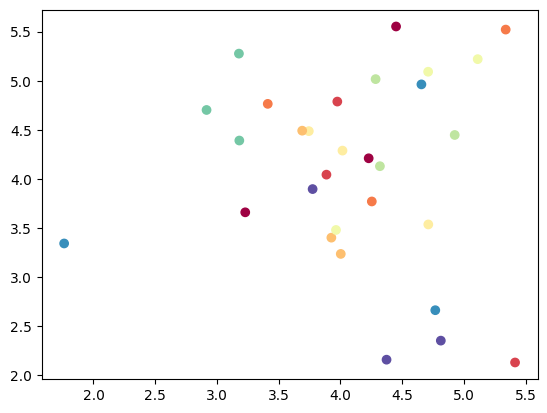

In [20]:
# Plotting the data points after PCA
colors = plt.cm.Spectral(np.linspace(0, 1, 10))
# plt.figure(figsize=(10,10))
plt.scatter(flat_output[:,0], flat_output[:,1], c=colors[labels_new.reshape(30).astype(int)], cmap=plt.cm.Spectral)
plt.show()
